In [1]:
cd src/notebooks/piControl/

/silor/boergel/paper/spatial_amo_baltic_sea/src/notebooks/piControl


In [2]:
import os
from glob import glob
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from eofs.standard import Eof

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from functions.helper_functions import *
from functions.xr_functions import *
from functions.wavelets import wavelet_cwt, wavelet_wct
from matplotlib.colors import LogNorm


In [3]:
def bin_data(period, power):
    bin1 = np.where((period > 4) & (period < 8)) 
    bin2 = np.where((period > 8) & (period < 16)) 
    bin3 = np.where((period > 16) & (period < 32)) 
    bin4 = np.where((period > 32) & (period < 64)) 
    bin5 = np.where((period > 64) & (period < 96))
    bin6 = np.where((period > 96) & (period < 128))
    bin7 = np.where((period > 128) & (period < 160))
    power1 = power[bin1].mean()
    power2 = power[bin2].mean()
    power3 = power[bin3].mean()
    power4 = power[bin4].mean()
    power5 = power[bin5].mean()
    power6 = power[bin6].mean()
    power7 = power[bin7].mean()

    return np.array([power1,power2,power3,power4,power5,power6, power7])

In [4]:
amopath = glob("/silor/boergel/paper/spatial_amo_baltic_sea/data/ocean/piControl/amo_no_rolling/*")

In [5]:
all_powers = []
all_models = []

for model in amopath:
    amo = xr.open_dataset(model, use_cftime = True)
    amo = amo / amo.std()
    wavelet = wavelet_cwt(amo, varname = "tos", timename = "time", remove_trend = True)
    wavelet.cwt()
    wavelet.power_spectra()
    power = wavelet.var * wavelet.glbl_power
    all_models.append(os.path.basename(model).split("amo_")[1].split("_piControl")[0])
    powers = bin_data(wavelet.period, power)
    all_powers.append(powers)

In [6]:
powers = np.asarray(all_powers)

In [7]:
def normalize_0_to_1(data):
    return (data - np.min(data, axis = 0))/(np.max(data, axis = 0) - np.min(data, axis = 0))

In [13]:
normed_power = normalize_0_to_1(powers) + 0.0001

In [19]:
df = pd.DataFrame(powers, index = all_models)

In [20]:
df.columns = ["4-8","8-16","16-32","32-64","64-96","96-128", "128-160"]

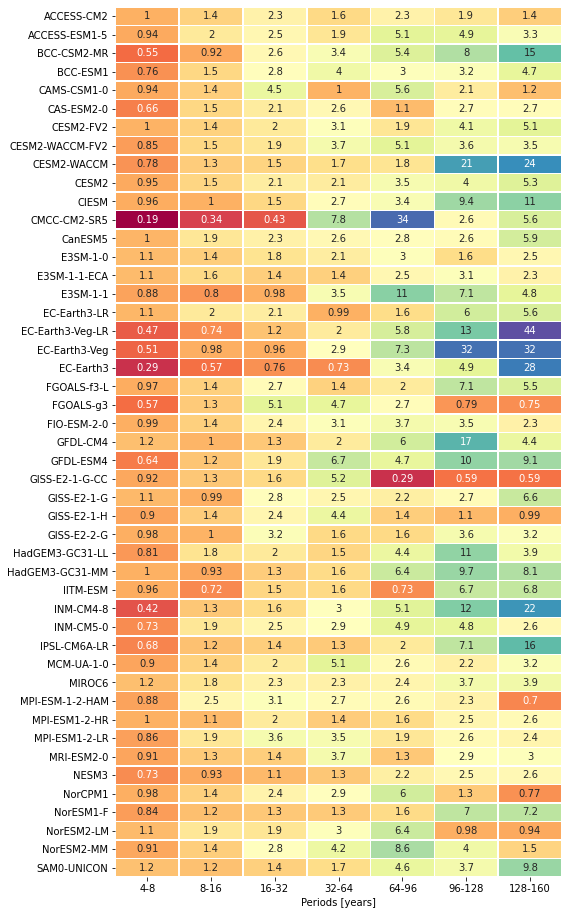

In [23]:
f, ax = plt.subplots(1, figsize = (8,16))
#cbar_ax = f.add_axes([.705, .3, .025, .3])

sns.heatmap(df, ax = ax,linewidths=0.5,square=False,annot=True,
            norm=LogNorm(), cmap="Spectral",cbar = False)
ax.set_xlabel("Periods [years]")
plt.savefig("../../../figures/power_distribution_cmip6.png", dpi = 400)